# Phase 2 — Trend & Relationship Analysis

## Overview
Analyzing long-term trends and relationships between climate variables and biodiversity metrics.

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 4)
print("Libraries imported.")

Libraries imported.


In [6]:
# Load Datasets
# Wildlife
wildlife = pd.read_csv("../data/wildlife_observations.csv", sep="\t", engine="python")
wildlife["eventDate"] = pd.to_datetime(wildlife["eventDate"], errors="coerce")

# Climate (long-format result logic reproduced for independence)
climate = pd.read_csv(
    "../data/POWER_Point_Monthly_20200101_20251231_021d90N_088d90E_LST.csv",
    skiprows=11
)
climate.replace([-999, -1000], np.nan, inplace=True)
print("Datasets loaded.")

Datasets loaded.


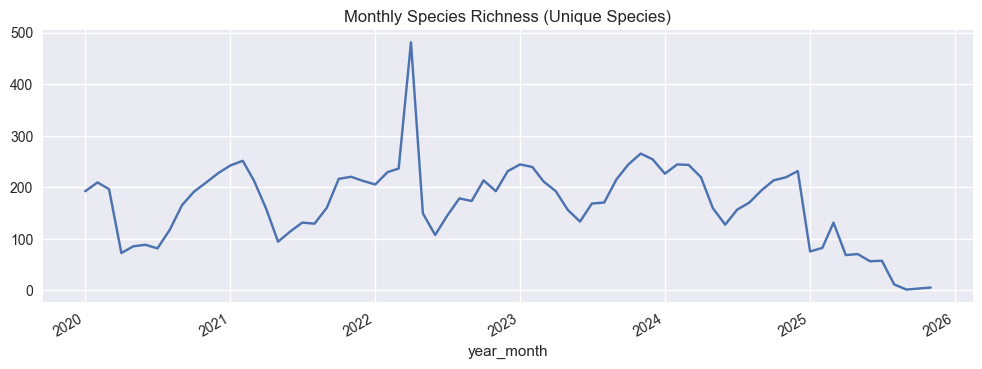

In [ ]:
# Wildlife Species Richness Over Time
wildlife["year_month"] = wildlife["eventDate"].dt.to_period("M")

species_richness = (
    wildlife
    .dropna(subset=["species", "year_month"])
    .groupby("year_month")["species"]
    .nunique()
    .to_timestamp()
)

species_richness.plot(
    title="Monthly Species Richness (Unique Species)"
)
plt.show()

In [ ]:
# Climate Data Transformation
months = ["JAN","FEB","MAR","APR","MAY","JUN",
          "JUL","AUG","SEP","OCT","NOV","DEC"]

climate_long = climate.melt(
    id_vars=["PARAMETER", "YEAR"],
    value_vars=months,
    var_name="MONTH",
    value_name="VALUE"
)

month_map = {
    "JAN":1,"FEB":2,"MAR":3,"APR":4,"MAY":5,"JUN":6,
    "JUL":7,"AUG":8,"SEP":9,"OCT":10,"NOV":11,"DEC":12
}

climate_long["MONTH_NUM"] = climate_long["MONTH"].map(month_map)

climate_long["DATE"] = pd.to_datetime(
    dict(
        year=climate_long["YEAR"],
        month=climate_long["MONTH_NUM"],
        day=15
    )
)

climate_long.set_index("DATE", inplace=True)

In [9]:
key_params = ["T2M", "RH2M", "ALLSKY_SFC_SW_DWN"]

climate_focus = climate_long[
    climate_long["PARAMETER"].isin(key_params)
]
print("Climate data transformed.")

Climate data transformed.


In [45]:
climate_features = climate_focus.pivot_table(
    index=climate_focus.index.to_period("M").to_timestamp(),
    columns="PARAMETER",
    values="VALUE",
    aggfunc="mean"
)
climate_features.head()

PARAMETER,RH2M,T2M
DATE,,
2020-01-01,73.36,18.15
2020-02-01,65.38,20.71
2020-03-01,67.19,26.24
2020-04-01,66.88,29.66
2020-05-01,77.71,29.40


In [15]:
print(climate_features.columns)

Index(['RH2M', 'T2M'], dtype='object', name='PARAMETER')


In [17]:
df = pd.concat(
    [species_richness, climate_features],
    axis=1
).dropna()

df = df.rename(columns={
    "T2M": "air_temperature",
    "RH2M": "humidity"
})

df.head()

,species,humidity,air_temperature
2020-01-01,192.0,73.36,18.15
2020-02-01,209.0,65.38,20.71
2020-03-01,196.0,67.19,26.24
2020-04-01,72.0,66.88,29.66
2020-05-01,85.0,77.71,29.40


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70 entries, 2020-01-01 to 2025-11-01
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   species          70 non-null     float64
 1   humidity         70 non-null     float64
 2   air_temperature  70 non-null     float64
dtypes: float64(3)
memory usage: 2.2 KB


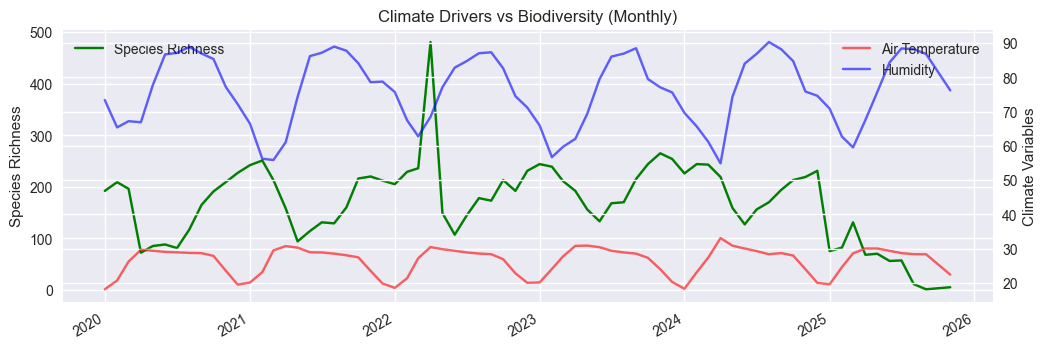

In [26]:
fig, ax1 = plt.subplots(figsize=(12,4))

df["species"].plot(
    ax=ax1,
    color="green",
    label="Species Richness"
)
ax1.set_ylabel("Species Richness")

ax2 = ax1.twinx()
df["air_temperature"].plot(
    ax=ax2,
    color="red",
    alpha=0.6,
    label="Air Temperature"
)
df["humidity"].plot(
    ax=ax2,
    color="blue",
    alpha=0.6,
    label="Humidity"
)
ax2.set_ylabel("Climate Variables")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.title("Climate Drivers vs Biodiversity (Monthly)")
plt.show()



In [ ]:

df["temp_lag_3"] = df["air_temperature"].shift(3)
df["hum_lag_3"] = df["humidity"].shift(3)

df_lag = df.dropna()

df_lag[[
    "species",
    "temp_lag_3",
    "hum_lag_3"
]].corr()


,species,temp_lag_3,hum_lag_3
species,1.000000,-0.163085,0.379243
temp_lag_3,-0.163085,1.000000,0.231344
hum_lag_3,0.379243,0.231344,1.000000


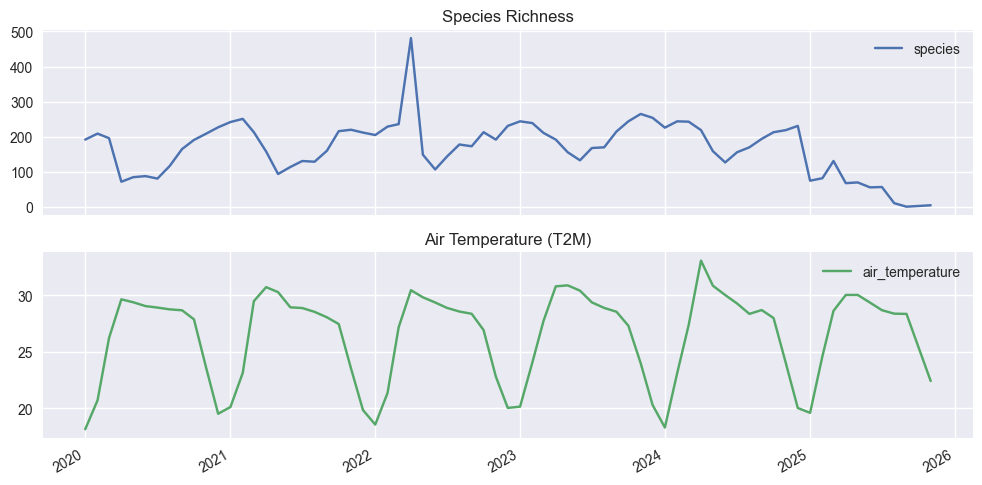

In [ ]:
# Temperature Relationship
df[["species", "air_temperature"]].plot(
    subplots=True,
    figsize=(12,6),
    title=["Species Richness", "Air Temperature (T2M)"]
)
plt.show()

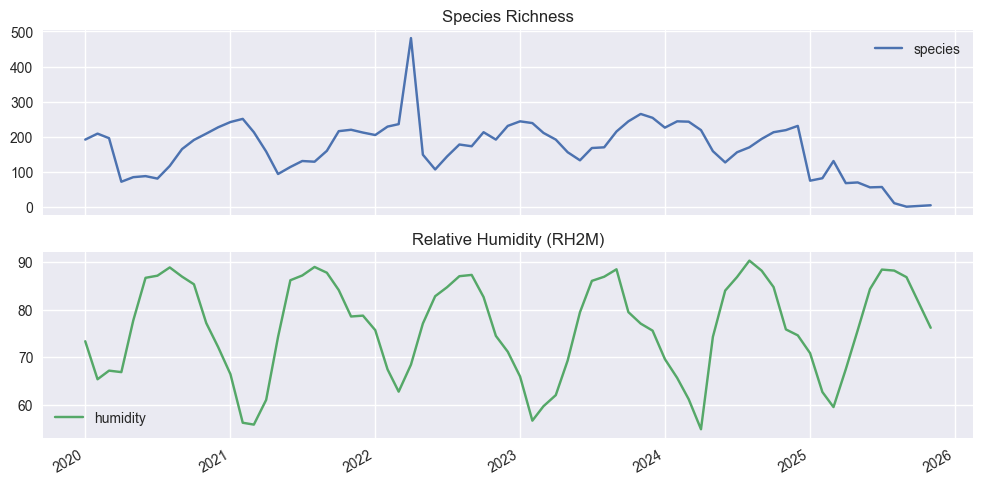

In [ ]:
# Humidity Relationship
df[["species", "humidity"]].plot(
    subplots=True,
    figsize=(12,6),
    title=["Species Richness", "Relative Humidity (RH2M)"]
)
plt.show()

In [ ]:
# Lagged Climate Effects
for lag in [1, 3, 6]:
    df[f"T2M_lag_{lag}"] = df["air_temperature"].shift(lag)
    df[f"RH2M_lag_{lag}"] = df["humidity"].shift(lag)

In [40]:
lag_corr = df[
    ["species", "T2M_lag_1", "T2M_lag_3", "T2M_lag_6"]
].corr()

lag_corr


,species,T2M_lag_1,T2M_lag_3,T2M_lag_6
species,1.000000,-0.396299,-0.163085,0.457935
T2M_lag_1,-0.396299,1.000000,0.250684,-0.536543
T2M_lag_3,-0.163085,0.250684,1.000000,-0.238870
T2M_lag_6,0.457935,-0.536543,-0.238870,1.000000


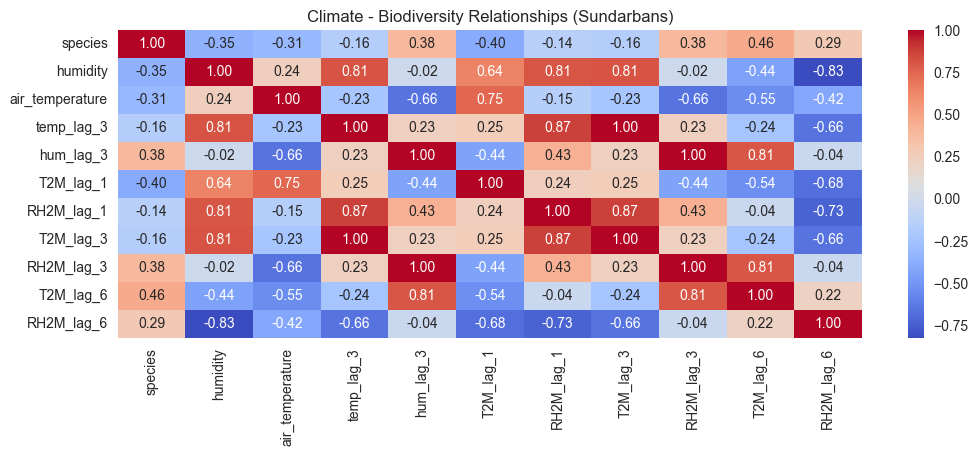

In [42]:
# Climate - Biodiversity Relationships (Sundarbans)
sns.heatmap(
    df.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Climate - Biodiversity Relationships (Sundarbans)")
plt.show()

In [46]:
df.head()


,species,humidity,air_temperature,temp_lag_3,hum_lag_3,T2M_lag_1,RH2M_lag_1,T2M_lag_3,RH2M_lag_3,T2M_lag_6,RH2M_lag_6
2020-01-01,192.0,73.36,18.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,209.0,65.38,20.71,NaN,NaN,18.15,73.36,NaN,NaN,NaN,NaN
2020-03-01,196.0,67.19,26.24,NaN,NaN,20.71,65.38,NaN,NaN,NaN,NaN
2020-04-01,72.0,66.88,29.66,18.15,73.36,26.24,67.19,18.15,73.36,NaN,NaN
2020-05-01,85.0,77.71,29.40,20.71,65.38,29.66,66.88,20.71,65.38,NaN,NaN


In [47]:
df.to_csv("../data/phase2_monthly_features.csv")
print("Phase 2 features saved.")

Phase 2 features saved.
